In [36]:
#Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import scipy.optimize as opt
import pandas as pd
from pandas import DataFrame, Series

import pint

import pims
import trackpy as tp

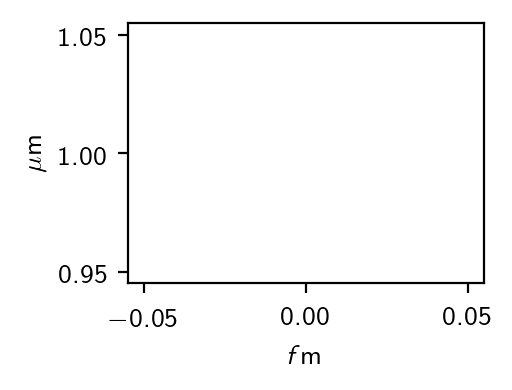

In [37]:
# From https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 

mpl.rcParams.update({'figure.dpi': 200})

mpl.rcParams.update({'font.size': 10})

ureg = pint.UnitRegistry()
column = 18*ureg.cm

fig, ax = plt.subplots(1,1,figsize=(column-0.5*ureg.cm).to(ureg.inch).magnitude*np.array([1,0.75])/3)

plt.plot([0,0],[1,1])
plt.xlabel(r"$f$m")
plt.ylabel(r"$\mu$m");

In [58]:
#Loading the tracking matrix from csv file 
filePath = "Tracking_Test30_20190617.dat"
t = pd.read_csv(filePath ,sep = "\t", index_col=0)
t = t.filter(["x","y","frame"])
t.head()

,x,y,frame
0,405.822911,272.577985,0
1,405.915240,272.560079,1
2,405.957725,271.894898,2
3,405.968736,271.216446,3
4,407.092074,270.371478,4


In [59]:
t.x = t.x*0.1805 #0.1805 um/px
t.y = t.y*0.1805 #0.1805 um/px
t = t.set_index(["frame"])
t.head()

,x,y
frame,,
0,73.251035,49.200326
1,73.267701,49.197094
2,73.275369,49.077029
3,73.277357,48.954569
4,73.480119,48.802052


In [60]:
#Loading the timestamps of the video to have the time of each position
tmstmp_filePath = r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test30_2019_06_17_16_54_47.dat"
timestamp = pd.read_csv(tmstmp_filePath, sep="\r", header = None,names=["time"])

#Calculation of timestamps in nanoseconds
timestamp["datetime"] =  pd.to_datetime(timestamp.time+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))
timestamp["ellapsed_time"] = (timestamp.datetime-timestamp.datetime[0])

#Timestamps to seconds and adding to t DataFrame 
t["time"] = timestamp.ellapsed_time.dt.total_seconds()
t.head()

,x,y,time
frame,,,
0,73.251035,49.200326,0.000
1,73.267701,49.197094,0.017
2,73.275369,49.077029,0.033
3,73.277357,48.954569,0.050
4,73.480119,48.802052,0.067


In [61]:
#Function to establish the centre of a circle inthe origin. 
import scipy.optimize as spo
def get_center(trj):
    
    def calc_R(xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((trj.x.values-xc)**2 + (trj.y.values-yc)**2)

    def f_2(c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        Ri = calc_R(*c)
        return Ri - Ri.mean()    

    center_estimate = 0, 0
    center, ir = spo.leastsq(f_2, center_estimate)
    return center

In [62]:
#Obtention of the circle centre defined by the trajectory of the particle 
center = get_center(t)
t["x0"] = t.x-center[0]
t["y0"] = t.y-center[1]

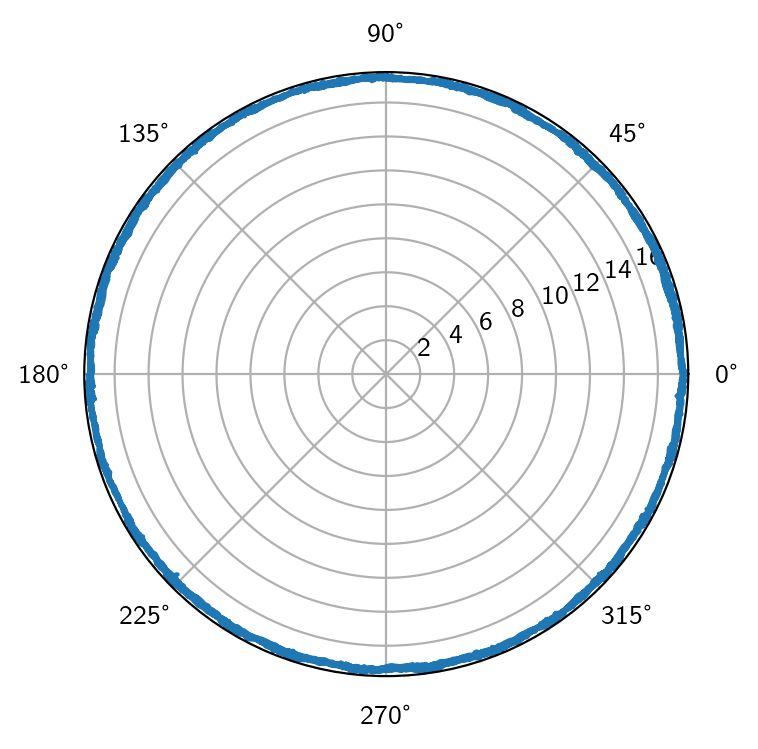

In [63]:
#New calculation of the ro and theta coordinates with the coordinates origin correction 
t["r"] = np.sqrt(t.x0**2 + t.y0**2)
t["theta"] = np.arctan2(t.y0,t.x0)

#Calculus of theta_prime (potential landscape reference system)
omega = 0.72
t["theta_prime"] = np.mod(np.unwrap(t.theta)-omega*t.time,2*np.pi) #np.mod = modulus

plt.polar(t.theta_prime,t.r)

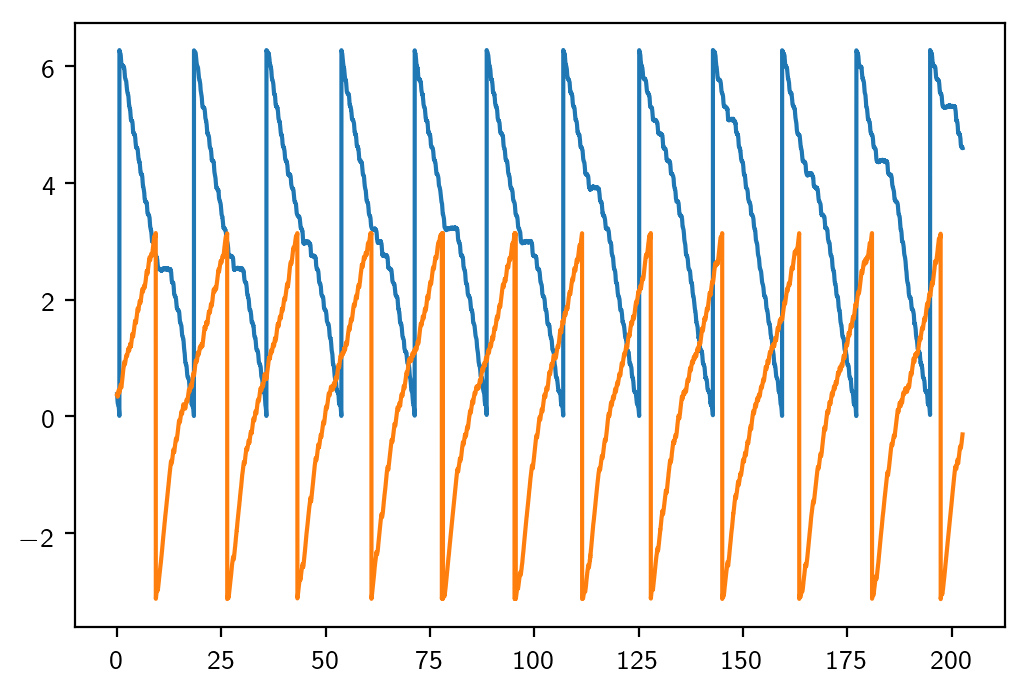

In [64]:
plt.plot(t.time, t.theta_prime)
plt.plot(t.time, t.theta)

In [65]:
t.head()

,x,y,time,x0,y0,r,theta,theta_prime
frame,,,,,,,,
0,73.251035,49.200326,0.000,16.326487,6.413741,17.541102,0.374321,0.374321
1,73.267701,49.197094,0.017,16.343153,6.410509,17.555434,0.373803,0.361562
2,73.275369,49.077029,0.033,16.350821,6.290444,17.519105,0.367263,0.343503
3,73.277357,48.954569,0.050,16.352808,6.167983,17.477367,0.360682,0.324682
4,73.480119,48.802052,0.067,16.555571,6.015466,17.614561,0.348518,0.300278


In [66]:
t.theta = t.theta_prime
t = t.filter(["x", "y", "time", "r", "theta"])
t.head()

,x,y,time,r,theta
frame,,,,,
0,73.251035,49.200326,0.000,17.541102,0.374321
1,73.267701,49.197094,0.017,17.555434,0.361562
2,73.275369,49.077029,0.033,17.519105,0.343503
3,73.277357,48.954569,0.050,17.477367,0.324682
4,73.480119,48.802052,0.067,17.614561,0.300278


In [67]:
t.to_csv(r"C:\Users\Eric\Desktop\Trajectory_Data.dat", sep="\t")

# Test if the Potential Landscape obtainment is the same as in previous version  

In [68]:
t["theta_prime_unwrap"] = np.unwrap(t.theta)#_prime)
t["d_theta_prime"] = t.theta_prime_unwrap.diff()

t["theta_dot_prime"] = t.d_theta_prime/t.time.diff()
t.head()

,x,y,time,r,theta,theta_prime_unwrap,d_theta_prime,theta_dot_prime
frame,,,,,,,,
0,73.251035,49.200326,0.000,17.541102,0.374321,0.374321,NaN,NaN
1,73.267701,49.197094,0.017,17.555434,0.361562,0.361562,-0.012759,-0.750497
2,73.275369,49.077029,0.033,17.519105,0.343503,0.343503,-0.018060,-1.128756
3,73.277357,48.954569,0.050,17.477367,0.324682,0.324682,-0.018821,-1.107080
4,73.480119,48.802052,0.067,17.614561,0.300278,0.300278,-0.024404,-1.435530


In [69]:
theta_bins = np.linspace(0,2*np.pi,1000)
t["bins"] = pd.cut(t.theta,theta_bins)#_prime,theta_bins)
t_grouped = t.groupby("bins").mean()
t.head() 

,x,y,time,r,theta,theta_prime_unwrap,d_theta_prime,theta_dot_prime,bins
frame,,,,,,,,,
0,73.251035,49.200326,0.000,17.541102,0.374321,0.374321,NaN,NaN,"(0.371, 0.377]"
1,73.267701,49.197094,0.017,17.555434,0.361562,0.361562,-0.012759,-0.750497,"(0.359, 0.365]"
2,73.275369,49.077029,0.033,17.519105,0.343503,0.343503,-0.018060,-1.128756,"(0.34, 0.346]"
3,73.277357,48.954569,0.050,17.477367,0.324682,0.324682,-0.018821,-1.107080,"(0.321, 0.327]"
4,73.480119,48.802052,0.067,17.614561,0.300278,0.300278,-0.024404,-1.435530,"(0.296, 0.302]"


lin fit slope =  0.7065987841222569 lin fit ind term =  0.05017962952353322


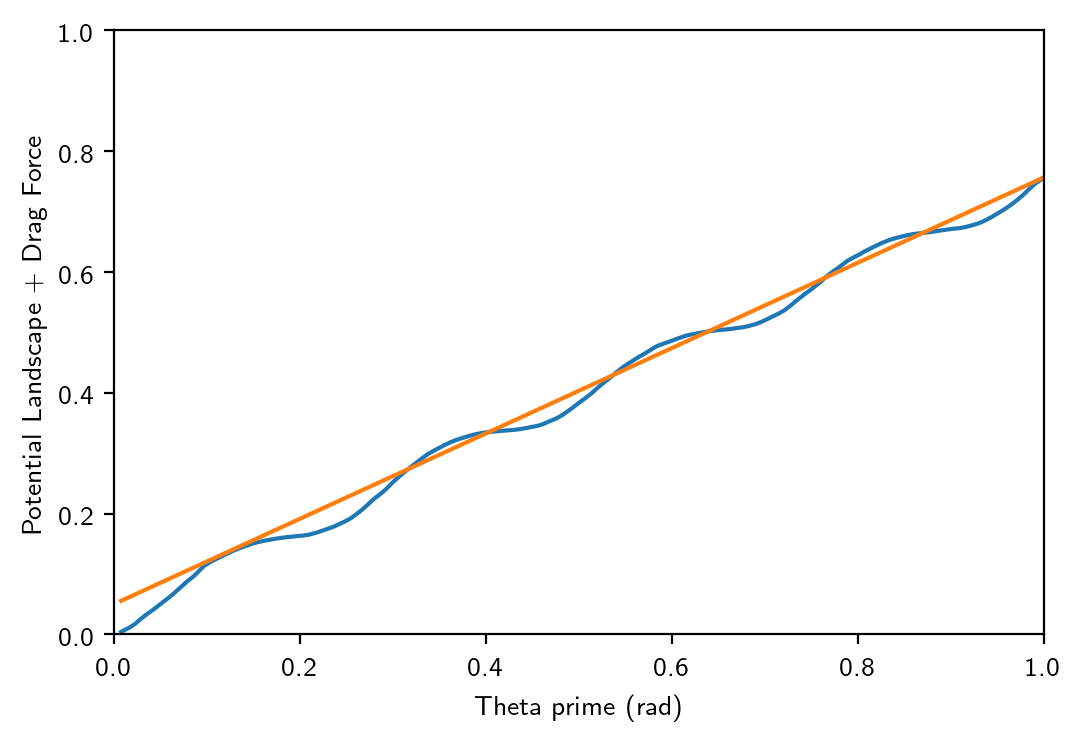

In [70]:
import scipy.integrate as scint

#interpolate the points where is no data to avoid problems integrating the function
theta_dot_prime_interpol = t_grouped["theta_dot_prime"].interpolate()
theta_prime_interpol = t_grouped["theta"].interpolate()

I_trap = scint.cumtrapz(-theta_dot_prime_interpol, theta_prime_interpol)

x = np.array(theta_prime_interpol[1:])
data = np.array(I_trap)
lin_fit_trap = np.polyfit(x, data, 1)

rect = np.polyval(lin_fit_trap, x)

plt.plot(x, data)
plt.plot(x, rect)

plt.xlabel("Theta prime (rad)")
plt.ylabel("Potential Landscape + Drag Force")
plt.xlim(0,1)
plt.ylim(0,1)
print("lin fit slope = ", lin_fit_trap[0], "lin fit ind term = ", lin_fit_trap[1])

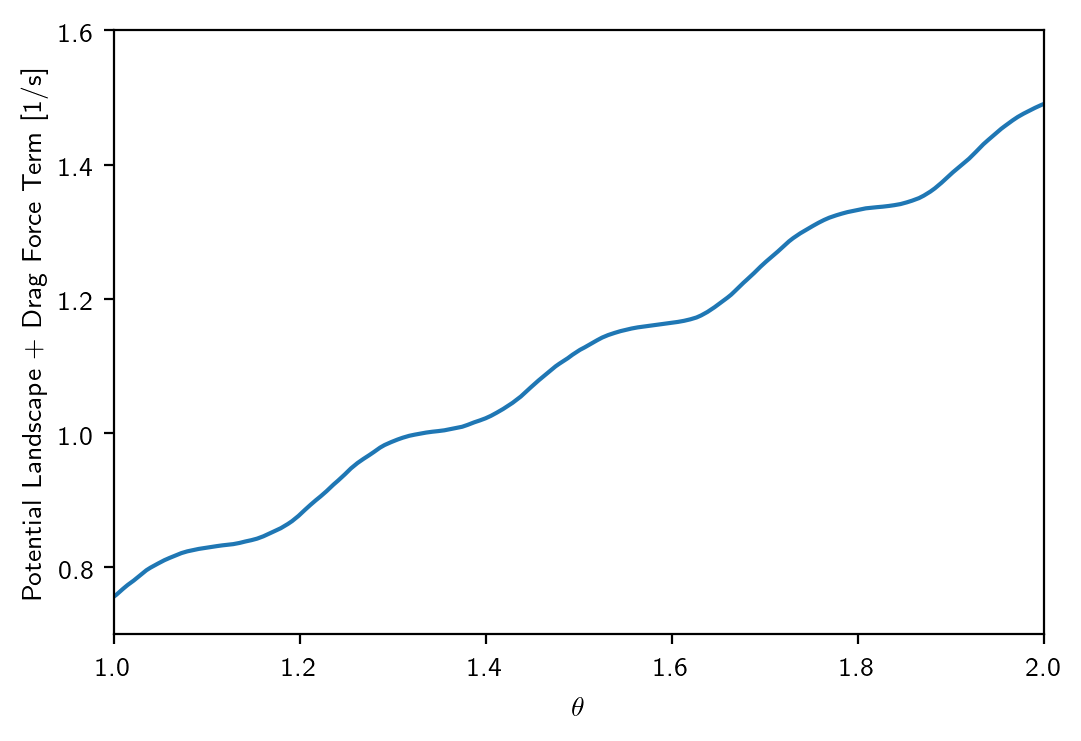

In [71]:
plt.plot(x, data)
plt.xlim(1,2)
plt.ylim(0.7,1.6)
plt.ylabel(r"Potential Landscape + Drag Force Term [1/s]")
plt.xlabel(r"$\theta$");

Text(0.5, 0, 'theta prime (rad)')

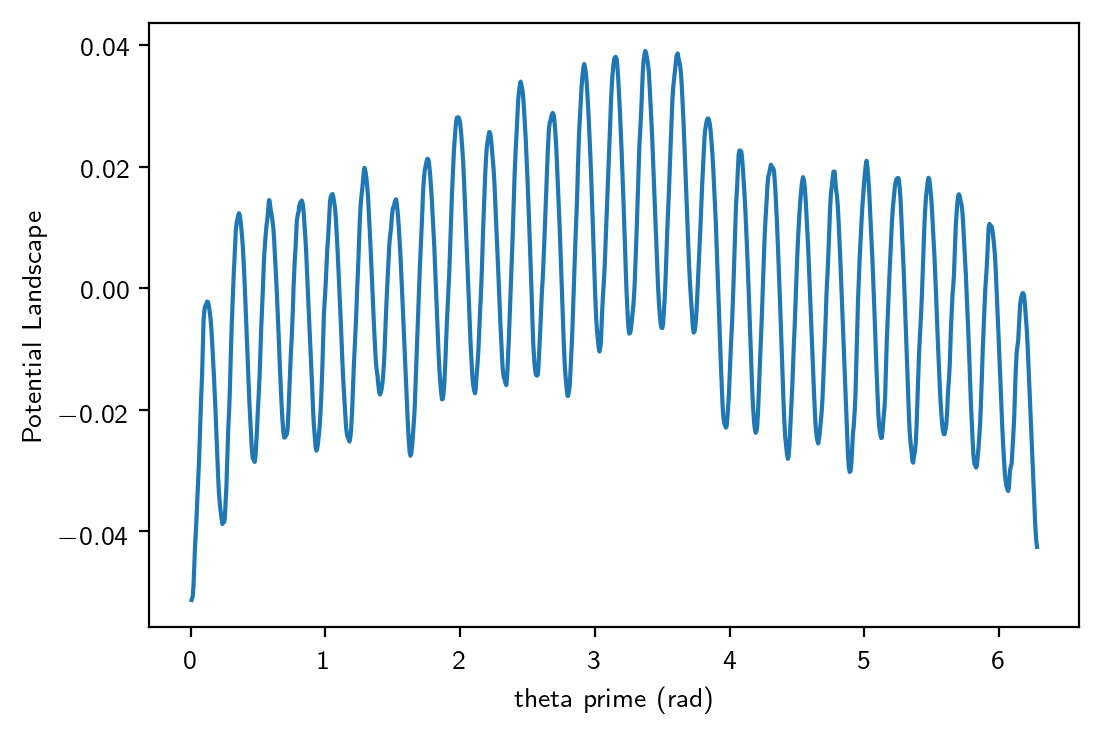

In [72]:
I_sim_rect = data-rect

plt.plot(x, I_sim_rect)#[:250])
plt.ylabel("Potential Landscape")
plt.xlabel("theta prime (rad)")

fit values: Amplitude =  -0.021829998599441333 ; Frequency =  27.02722971203291 ; Phase =  -4.995495462891675 ; Mean =  -3.18827574005581e-16


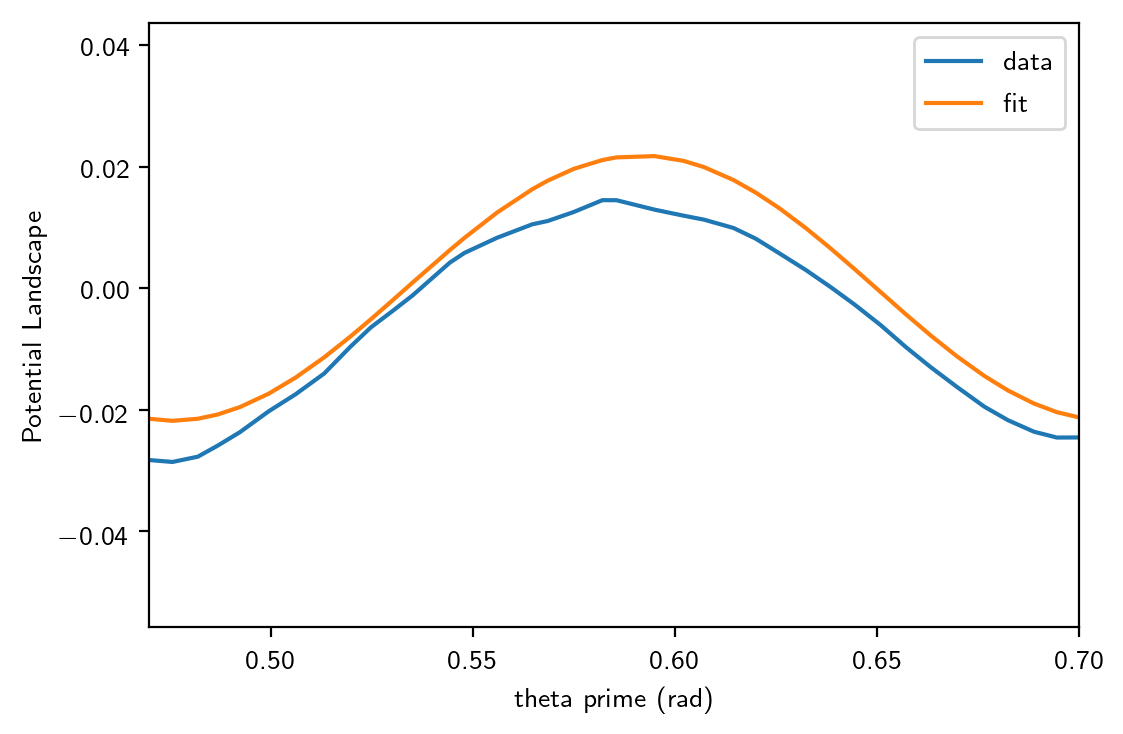

In [73]:
#estimation of the sinusoidal function prameters 
guess_mean = np.mean(I_sim_rect)
guess_std = 3*np.std(I_sim_rect)/(2**0.5)
guess_phase = 0
guess_freq = 27
guess_amp = 0.005

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = guess_std*np.sin(guess_freq*x+guess_phase) #+ guess_mean

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters
optimize_func = lambda y: y[0]*np.sin(y[1]*x+y[2]) + y[3] - I_sim_rect
est_amp, est_freq, est_phase, est_mean = opt.leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

# recreate the fitted curve using the optimized parameters
data_fit = est_amp*np.sin(est_freq*x+est_phase) + est_mean

print('fit values: Amplitude = ', est_amp, '; Frequency = ', est_freq, '; Phase = ', est_phase, '; Mean = ', est_mean)

plt.plot(x, I_sim_rect, label='data')#[:250])
plt.plot(x, data_fit, label='fit')
#plt.plot(t_grouped["theta_prime"][:len(I_sim_rect)], data_first_guess, '-', label='guess fit')
plt.ylabel("Potential Landscape")
plt.xlabel("theta prime (rad)")
plt.xlim(0.47, 0.7)
plt.legend()